***Data Pre-Processor***


In [2]:
%run DeepFake_Dataloader.py
%run utils.py

In [3]:
import h5py
import torch
import numpy as np

In [4]:
# batch_sz = 128 
batch_sz = 10
dataloader = get_preprocessors(batch_size=batch_sz)
total_imgs = len(dataloader) * batch_sz
print(total_imgs)
total_imgs = !find {img_root} -type f -iname "*.png" | wc -l
total_imgs = int(total_imgs[0])
print(total_imgs)

('Classes: '
 "['lsun_bedrooms', "
 "'lsun_cats', "
 "'lsun_churches', "
 "'stylegan1_bedrooms', "
 "'stylegan2_cats', "
 "'stylegan2_churches']")
('Indices: '
 "{'lsun_bedrooms': "
 "0, 'lsun_cats': "
 '1, '
 "'lsun_churches': "
 '2, '
 "'stylegan1_bedrooms': "
 '3, '
 "'stylegan2_cats': "
 '4, '
 "'stylegan2_churches': "
 '5}')
60010
60002


In [ ]:
progress = ProgressMonitor(length=total_imgs)
rad_len  = 182
with h5py.File('LSUN_BCC_256.hdf5', 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, rad_len), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    img_size  = f.create_dataset('img_size',  (total_imgs,),     dtype='i')
    data_size = f.create_dataset('data_size', (total_imgs,),     dtype='i')
    
    for i, (img_data, target, origin_dataset, _, _) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(img_data.shape[0]):
            idx = start_idx + j
            progress.update(1, 0)
            if (target[j] > 1):
                print(target[j])
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]
            img_size[idx]  = data_img_size[origin_dataset[j]]
            data_size[idx] = rad_size[origin_dataset[j]]
        

In [ ]:
import matplotlib.pyplot as plt


with h5py.File('LSUN_BCC_256.hdf5', 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[200])
    for i in range(10):
        plt.plot(dset[np.random.randint(20000)])
#         plt.show()
    plt.show()

In [ ]:
with h5py.File('LSUN_Cars.hdf5', 'r') as f:
    dset = f['lbl_data']
    for i in range(len(dset)):
        if dset[i] != 1 and dset[i] != 0:
            print(dset[i])

In [ ]:
!gcloud auth activate-service-account --key-file ./playground-270702-4d2df0765336.json

In [ ]:
# auth.authenticate_user()

project_id = 'playground-270702'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'img-hosting-bucket'
!gsutil -m cp -r /home/jupyter/CSE253_FinalProject/LSUN_BCC_256.hdf5 gs://{bucket_name}/

In [ ]:
!wget https://storage.googleapis.com/img-hosting-bucket/LSUN_BCC_256.hdf5

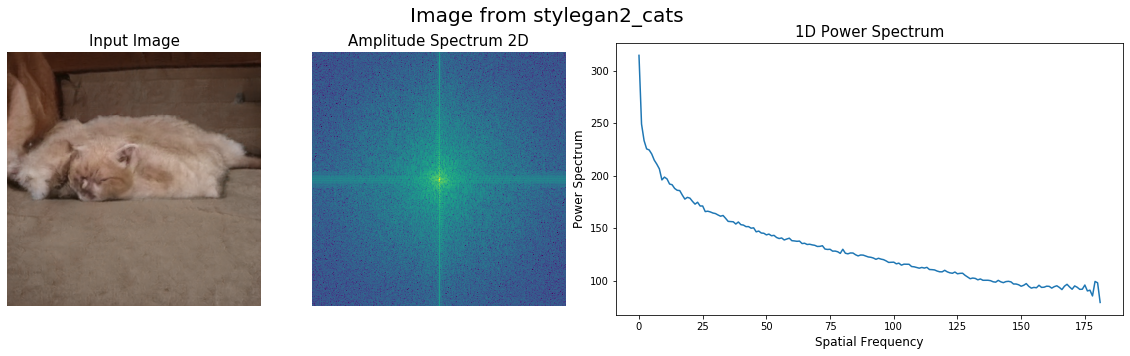

In [5]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from PIL import Image
import random
from torchvision import transforms

file_name = './imgs/class_1'

(img_data, target, origin_dataset, img, ms_img) = next(iter(dataloader))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col',
                        gridspec_kw={'hspace': 1, 'wspace': 0.15, 'width_ratios': [1, 1, 2]},
                        figsize=(20, 5))
fig.suptitle('Image from ' + origin_dataset[0], fontsize=20)

ax1.axis('off')
ax2.axis('off')

ax1.set_title('Input Image',           size=15)
ax2.set_title('Amplitude Spectrum 2D', size=15)
ax3.set_title('1D Power Spectrum',     size=15)

ax1.imshow(img[0])
ax2.imshow(ms_img[0])

plt.xlabel('Spatial Frequency', fontsize=12)
plt.ylabel('Power Spectrum',    fontsize=12)
ax3.plot(img_data[0])

plt.savefig(file_name + '.jpg', dpi=300)
plt.show()
